In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel

import netCDF4
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
era5_fp = '../data/cmip/6d54301da007a125ad83767ca9e617ca.nc'
cesm_fp = '../data/cmip/ts_Amon_CESM2_historical_r1i1p1f1_gn_19500115-19991215.nc'
era5 = netCDF4.Dataset(era5_fp)
cesm = netCDF4.Dataset(cesm_fp)

In [3]:
downsample = nn.Upsample(size = (32, 64), mode = 'bicubic')
upsample = nn.Upsample(size = (192, 288), mode = 'bicubic')

In [4]:
x = np.array(cesm['ts'])
x = x - 273.15
x = np.flip(x, axis = 1)
x = torch.tensor(x.copy())[:,None]
x_mu = torch.tensor(np.array([torch.mean(x[i::12], axis = 0) for i in range(12)]))
x = x - torch.tile(x_mu, (50, 1, 1, 1))

x = x.reshape(-1, 12, 192, 288)
x = downsample(x)

y = np.array(era5['t2m'])
y = y - 273.15
# y = np.flip(y, axis = 1)
y = torch.tensor(y.copy())[:,None]
y_mu = torch.tensor(np.array([torch.mean(y[i::12], axis = 0) for i in range(12)]))
y = y - torch.tile(y_mu, (50, 1, 1, 1))

y = y.reshape(-1, 12, 721, 1440)
y = downsample(y)

train_data = TensorDataset(x[0:500], y[0:500])
train_loader = DataLoader(train_data, batch_size=16, shuffle=False)

In [5]:
lam = 0.02
lam1, lam2 = np.sqrt(lam), np.sqrt(1-lam)
sigma = 0.0
model = UNetModel(dim=(12, 32, 64),
                  num_channels=64, 
                  num_res_blocks=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [6]:
n_epochs = 1000
for epoch in trange(n_epochs):
    for i, data in enumerate(train_loader):
        x1 = data[1].to(device)
        x0 = lam1*data[0].to(device) + lam2*torch.randn_like(data[0]).to(device)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt)
        loss = torch.mean((vt - ut)**2)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
with torch.no_grad():
    yhat = node.trajectory(
        lam1*x.to(device) + lam2*torch.randn_like(x).to(device),
        t_span=torch.linspace(0, 1, 2, device=device),
    )
yhat = yhat[-1].squeeze().detach().cpu()
yhat1 = upsample(yhat)

with torch.no_grad():
    yhat = node.trajectory(
        lam1*x.to(device) + lam2*torch.randn_like(x).to(device),
        t_span=torch.linspace(0, 1, 2, device=device),
    )
yhat = yhat[-1].squeeze().detach().cpu()
yhat2 = upsample(yhat)

with torch.no_grad():
    yhat = node.trajectory(
        lam1*x.to(device) + lam2*torch.randn_like(x).to(device),
        t_span=torch.linspace(0, 1, 2, device=device),
    )
yhat = yhat[-1].squeeze().detach().cpu()
yhat3 = upsample(yhat)

In [8]:
yhat1 = yhat1.reshape(-1, 192, 288)
yhat2 = yhat2.reshape(-1, 192, 288)
yhat3 = yhat3.reshape(-1, 192, 288)
y = upsample(x).reshape(-1, 192, 288)

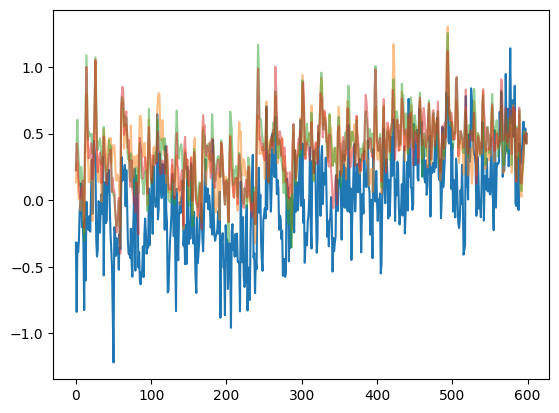

In [9]:
plt.plot(torch.mean(y, axis = (1, 2)))
plt.plot(torch.mean(yhat1, axis = (1, 2)), alpha = 0.5)
plt.plot(torch.mean(yhat2, axis = (1, 2)), alpha = 0.5)
plt.plot(torch.mean(yhat3, axis = (1, 2)), alpha = 0.5)
plt.show()

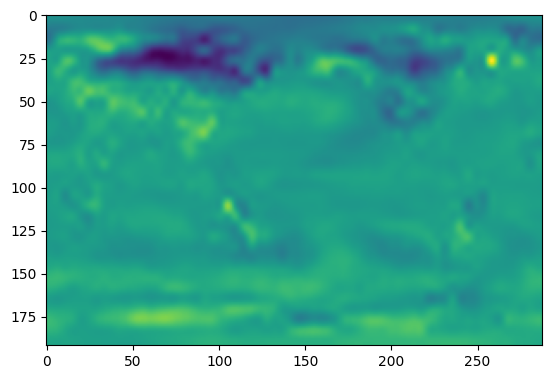

In [12]:
plt.imshow(y[0])

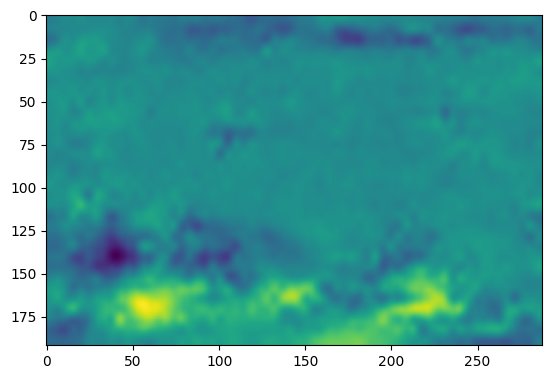

In [14]:
plt.imshow(yhat3[0])

In [31]:
import neuralop as op
from neuralop.models import FNO, TFNO

class OperatorFlow(nn.Module):
    def __init__(self, n_modes, hidden_channels, in_channels, out_channels):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        time_embed_dim = hidden_channels
        self.time_embed = nn.Sequential(
            nn.Linear(1, in_channels),
            nn.Tanh(),
            nn.Linear(in_channels, in_channels)
        )
        
        self.fno = TFNO(n_modes=n_modes, 
                       hidden_channels=hidden_channels, 
                       in_channels=in_channels, 
                       out_channels=out_channels)

    def forward(self, t, x):
        
        if not torch.is_tensor(t):
            t = torch.tensor([t], device=x.device)

        if t.dim() == 0:
            t = t.expand(x.size(0), 1)
        elif t.dim() == 1:
            t = t[:, None]

        t_embed = self.time_embed(t) 
        t_embed = t_embed[:,:,None,None]
        xt = x + t_embed
        
        return self.fno(xt)


from torchdiffeq import odeint
class OperatorODE(nn.Module):
    def __init__(self, odefunc, solver='dopri5'):
        super().__init__()
        self.odefunc = odefunc
        self.solver = solver

    def forward(self, x0, t_span):
        return odeint(self.odefunc, x0, t_span, method=self.solver, sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [32]:
model = OperatorFlow(n_modes = (32, 64), 
               hidden_channels = 32, 
               in_channels=12,
               out_channels=12)
model = model.to(device)
sigma = 0.0
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
node = OperatorODE(model)

In [33]:
lam = 0.05
lam1, lam2 = np.sqrt(lam), np.sqrt(1-lam)

n_epochs = 1000
for epoch in trange(n_epochs):
    for i, data in enumerate(train_loader):
        x1 = data[1].to(device)
        x0 = lam1*data[0].to(device) + lam2*torch.randn_like(x1).to(device)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt)
        loss = torch.mean((vt - ut)**2)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [34]:
with torch.no_grad():
    yhat1 = lam1*x.to(device) + lam2*torch.randn_like(x).to(device)
    t_seq = torch.linspace(0, 1, 20)
    h = torch.diff(t_seq)
    for i in tqdm(t_seq):
        t = i.to(device)
        yhat1 += h[0]*model(t, yhat1)

    yhat1 = yhat1.detach().cpu()
    yhat1 = upsample(yhat1)

with torch.no_grad():
    yhat2 = lam1*x.to(device) + lam2*torch.randn_like(x).to(device)
    t_seq = torch.linspace(0, 1, 20)
    h = torch.diff(t_seq)
    for i in tqdm(t_seq):
        t = i.to(device)
        yhat2 += h[0]*model(t, yhat2)

    yhat2 = yhat2.detach().cpu()
    yhat2 = upsample(yhat2)

with torch.no_grad():
    yhat3 = lam1*x.to(device) + lam2*torch.randn_like(x).to(device)
    t_seq = torch.linspace(0, 1, 20)
    h = torch.diff(t_seq)
    for i in tqdm(t_seq):
        t = i.to(device)
        yhat3 += h[0]*model(t, yhat3)

    yhat3 = yhat3.detach().cpu()
    yhat3 = upsample(yhat3)

y2 = upsample(y).reshape(-1, 192, 288)
yhat1 = yhat1.reshape(-1, 192, 288)
yhat2 = yhat2.reshape(-1, 192, 288)
yhat3 = yhat3.reshape(-1, 192, 288)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

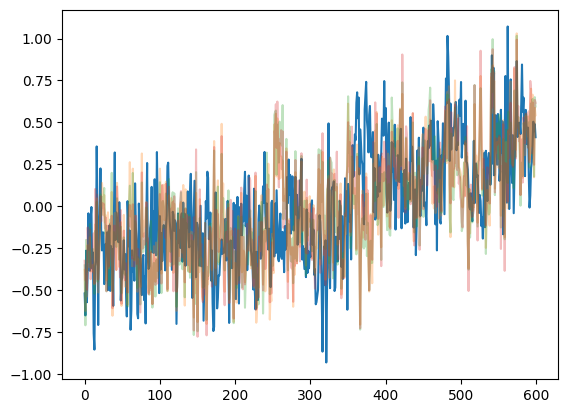

In [35]:
plt.plot(torch.mean(y2, axis = (1, 2)))
plt.plot(torch.mean(yhat1, axis = (1, 2)), alpha = 0.3)
plt.plot(torch.mean(yhat2, axis = (1, 2)), alpha = 0.3)
plt.plot(torch.mean(yhat3, axis = (1, 2)), alpha = 0.3)
plt.show()

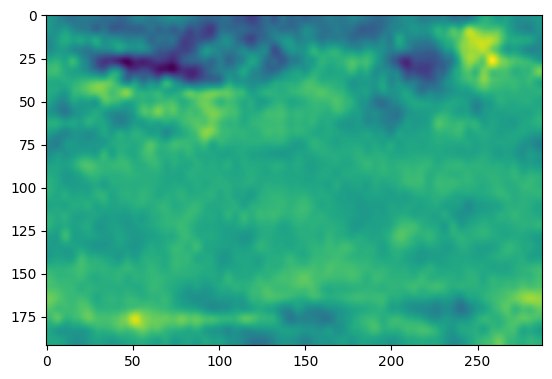

In [36]:
plt.imshow(yhat1[0])

In [25]:
with torch.no_grad():
    yhat1 = lam1*x.to(device) + lam2*torch.randn_like(x).to(device)
    t_seq = torch.linspace(0, 1, 20)
    h = torch.diff(t_seq)
    for i in tqdm(t_seq):
        t = i.to(device)
        yhat1 += h[0]*model(t, yhat1)

    yhat1 = yhat1.detach().cpu()
    yhat1 = upsample(yhat1)

  0%|          | 0/20 [00:00<?, ?it/s]

In [26]:
yhat1 = upsample(y_mu)[:,0][None,] + yhat1
yhat1 = yhat1[0]

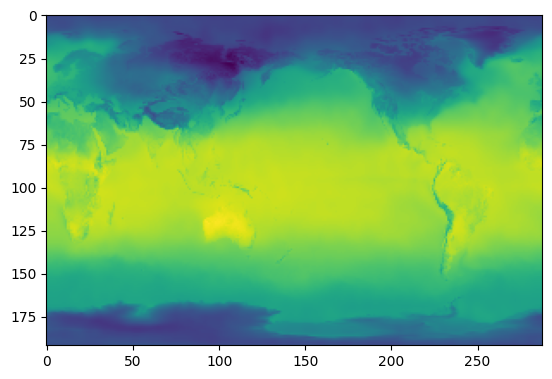

In [27]:
plt.imshow(yhat1[0])

In [28]:
z = torch.randn_like(x).to(device)
with torch.no_grad():
    yhat1 = lam1*x.to(device) + lam2*z
    t_seq = torch.linspace(0, 1, 20)
    h = torch.diff(t_seq)
    for i in tqdm(t_seq):
        t = i.to(device)
        yhat1 += h[0]*model(t, yhat1)

    yhat1 = yhat1.detach().cpu()
    yhat1 = upsample(yhat1)

with torch.no_grad():
    yhat2 = lam1*x.to(device) + lam2*(z + 0.1)
    t_seq = torch.linspace(0, 1, 20)
    h = torch.diff(t_seq)
    for i in tqdm(t_seq):
        t = i.to(device)
        yhat2 += h[0]*model(t, yhat2)

    yhat2 = yhat2.detach().cpu()
    yhat2 = upsample(yhat2)

yhat1 = yhat1.reshape(-1, 192, 288)
yhat2 = yhat2.reshape(-1, 192, 288)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

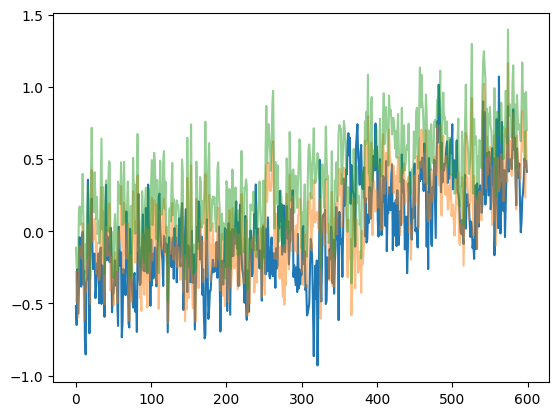

In [30]:
plt.plot(torch.mean(y2, axis = (1, 2)))
plt.plot(torch.mean(yhat1, axis = (1, 2)), alpha = 0.5)
plt.plot(torch.mean(yhat2, axis = (1, 2)), alpha = 0.5)
plt.show()